In [40]:
import snap
import re

# ENCRYPT COZ POST ID CAN ONLY BE INT

def convert_to_integer(post_id):
    base = 36  # 10 digits + 26 letters

    # Remove leading and trailing single quotes if present
    post_id = post_id.strip("'")

    # Convert each character to its corresponding integer value
    int_values = [int(c, base) for c in post_id]

    # Combine the integer values to get a unique integer for the whole string
    result = 0
    for value in int_values:
        result = result * base + value

    return result

# Create a dictionary to map from and to post IDs to edge IDs
post_id_pair_to_edge_id = {}

# Create a bipartite graph
G = snap.TNEANet.New()

# Load post crosslinks info
with open('formatted_data_file.txt', 'r') as file:
    data = file.read()

# Split the data into lines
lines = data.strip().split('\n')

# Mapping between community and user names and their node IDs
community_to_id = {}
user_to_id = {}

## Add nodes and edges to the bipartite graph
for line in lines:
    parts = re.split(r'\t|\s', line)

    # Extract values into variables
    source_community = parts[0]
    target_community = parts[1]
    post_id_source = parts[2]
    timestamp_source = parts[3] + " " + parts[4]  # Combine date and time
    user = parts[5]
    post_id_target = parts[6]
    timestamp_target = parts[7] + " " + parts[8]  # Combine date and time
    
    # Add nodes if they don't exist
    if source_community not in community_to_id:
        source_community_id = G.AddNode()
        community_to_id[source_community] = source_community_id
    else:
        source_community_id = community_to_id[source_community]

    if user not in user_to_id:
        user_id = G.AddNode()
        user_to_id[user] = user_id
    else:
        user_id = user_to_id[user]

    if target_community not in community_to_id:
        target_community_id = G.AddNode()
        community_to_id[target_community] = target_community_id
    else:
        target_community_id = community_to_id[target_community]

    # Add edges
    edge_id = G.AddEdge(user_id, target_community_id)

    # Add attributes to the edges
    G.AddIntAttrDatE(edge_id, convert_to_integer(post_id_source), "from_post_id")
    G.AddIntAttrDatE(edge_id, convert_to_integer(post_id_target), "to_post_id")

    # Add entry to the dictionary
    post_id_pair_to_edge_id[(convert_to_integer(post_id_source), convert_to_integer(post_id_target))] = edge_id

# Load label info
with open('label_info.tsv', 'r') as file:
    label_info = file.read()

# Split label info into lines
label_lines = label_info.strip().split('\n')

# Add sentiment attribute to edges
for label_line in label_lines:
    parts = label_line.split()
    if len(parts) != 3:
        print(f"Skipping label line: {label_line}")
        continue

    post_id_from, post_id_to, sentiment = parts[0][1:-1], parts[1][:-1], parts[2]
    # Convert alphanumeric post IDs to integers
    post_id_from_int = convert_to_integer(post_id_from)
    post_id_to_int = convert_to_integer(post_id_to)

    # Check if the pair exists in the dictionary
    if (post_id_from_int, post_id_to_int) in post_id_pair_to_edge_id:
        # Retrieve the edge ID from the dictionary
        edge_id = post_id_pair_to_edge_id[(post_id_from_int, post_id_to_int)]

        # Map sentiment values to 1 and 0
        sentiment_value = 1 if sentiment == 'burst' else 0 

        # Add sentiment attribute to edges
        G.AddIntAttrDatE(edge_id, sentiment_value, "sentiment")

# Print the total number of nodes and edges
print("Total Nodes:", G.GetNodes())
print("Total Edges:", G.GetEdges())

Total Nodes: 180283
Total Edges: 286561


Filtered User IDs: [16, 22, 25, 35, 38, 61, 69, 72, 74, 77, 83, 86, 92, 103, 106, 109, 114, 116, 118, 120, 126, 131, 134, 140, 146, 152, 159, 168, 172, 175, 187, 191, 197, 199, 202, 208, 212, 214, 217, 222, 225, 241, 248, 251, 264, 270, 290, 293, 295, 298, 303, 306, 308, 310, 311, 314, 316, 318, 321, 324, 325, 334, 337, 348, 350, 352, 362, 366, 373, 376, 378, 380, 383, 389, 391, 394, 405, 410, 415, 417, 423, 430, 436, 438, 442, 445, 454, 459, 462, 468, 471, 477, 480, 492, 496, 500, 504, 509, 512, 517, 523, 525, 530, 537, 541, 552, 554, 562, 567, 570, 573, 577, 584, 586, 595, 599, 600, 607, 609, 611, 615, 630, 641, 646, 652, 663, 683, 724, 729, 732, 738, 740, 744, 751, 753, 754, 761, 762, 763, 768, 770, 774, 782, 784, 786, 791, 794, 796, 801, 805, 807, 809, 814, 817, 826, 830, 836, 844, 845, 847, 849, 857, 859, 861, 866, 879, 881, 889, 897, 902, 906, 908, 920, 923, 925, 927, 934, 937, 939, 941, 944, 946, 950, 953, 960, 967, 970, 976, 978, 981, 983, 990, 997, 1003, 1007, 1013, 1014, 1017

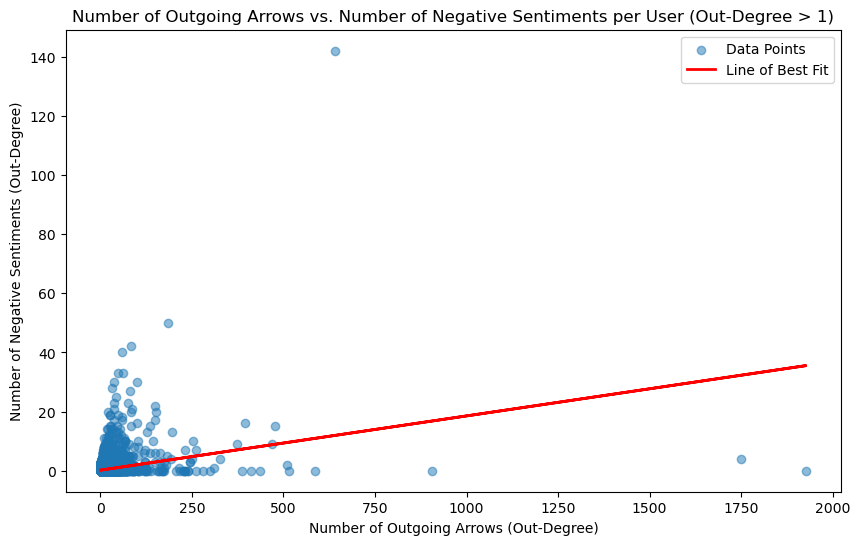

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Initialize dictionaries to store sentiment counts for users
user_out_degree = {}
user_negative_sentiments = {}

# Iterate through edges and sentiment attributes
for edge in G.Edges():
    user_id = edge.GetSrcNId()
    sentiment = G.GetIntAttrDatE(edge.GetId(), "sentiment")

    # Debugging information
    # print("Edge:", edge.GetId(), "User ID:", user_id, "Sentiment:", sentiment)

    # Count outgoing arrows for the corresponding user
    if user_id not in user_out_degree:
        user_out_degree[user_id] = 0
    user_out_degree[user_id] += 1

    # Count negative sentiments for the corresponding user
    if sentiment == 1:
        if user_id not in user_negative_sentiments:
            user_negative_sentiments[user_id] = 0
        user_negative_sentiments[user_id] += 1

# Filter users with out-degrees greater than 1
filtered_user_ids = [user_id for user_id, out_degree in user_out_degree.items() if out_degree > 1]

# Create lists for plotting
out_degrees = [user_out_degree.get(user_id, 0) for user_id in filtered_user_ids]
negative_sentiments = [user_negative_sentiments.get(user_id, 0) for user_id in filtered_user_ids]

# Convert lists to numpy arrays
X = np.array(out_degrees).reshape(-1, 1)
y = np.array(negative_sentiments)

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the y values based on the fitted model
y_pred = model.predict(X)

# Debugging information
print("Filtered User IDs:", filtered_user_ids)

# Plotting the graph with the line of best fit
plt.figure(figsize=(10, 6))
plt.scatter(out_degrees, negative_sentiments, alpha=0.5, label='Data Points')
plt.plot(X, y_pred, color='red', linewidth=2, label='Line of Best Fit')
plt.title('Number of Outgoing Arrows vs. Number of Negative Sentiments per User (Out-Degree > 1)')
plt.xlabel('Number of Outgoing Arrows (Out-Degree)')
plt.ylabel('Number of Negative Sentiments (Out-Degree)')
plt.legend()
plt.show()

In [60]:
import snap
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")


# Calculate precision for the class '1' (negative sentiments) on the test set
precision = precision_score(y_test, y_pred, average='micro', labels=[1])
print(f"Precision for negative sentiments on the test set: {precision}")



Accuracy on the test set: 0.8277665995975855
Precision for negative sentiments on the test set: 0.22580645161290322


In [7]:
from collections import defaultdict

# Assuming your data is in a file named 'formatted_data.txt'
file_path = 'formatted_data_file.txt'

# Dictionary to store counts of unique 5th index values
counts = defaultdict(int)

# Open the file and iterate through each line
with open(file_path, 'r') as file:
    for line in file:
        # Split the line into values
        values = line.split()

        # Check if there is a 5th index value
        if len(values) > 4:
            # Increment the count for the 5th index value
            counts[values[5]] += 1

# Print the results
for value, count in counts.items():
    print(f"Value: {value}, Count: {count}")


Value: Samwise_Gardner, Count: 1
Value: HarryBlessKnapp, Count: 1
Value: morbetter, Count: 1
Value: primeoflife, Count: 1
Value: dkramer, Count: 1
Value: russianpotato, Count: 2
Value: TotesBlazed, Count: 1
Value: Indiefied, Count: 13
Value: ManWithoutModem, Count: 185
Value: AwkwardDev, Count: 1
Value: Meow_dog, Count: 1
Value: nov3a4, Count: 3
Value: Throwaway_4_opinions, Count: 26
Value: bvbblepop, Count: 1
Value: silentobservant, Count: 1
Value: sdf2600, Count: 1
Value: CheezeCaek2, Count: 1
Value: wemblinger, Count: 1
Value: PimpinNinja, Count: 1
Value: rbisconti97, Count: 1
Value: What0TheFDR, Count: 3
Value: sigmastorm7, Count: 1
Value: bahanna, Count: 1
Value: _Doctor_, Count: 4
Value: TexasWithADollarsign, Count: 3
Value: lepton, Count: 3
Value: bugpoker, Count: 8
Value: LexusGS300, Count: 1
Value: ReBurnInator, Count: 3
Value: xdisk, Count: 10
Value: residentchubbychaser, Count: 1
Value: makenzie71, Count: 3
Value: The-Duck-Of-Death, Count: 1
Value: CDN_Rattus, Count: 1
Value

Value: ans136, Count: 1
Value: plmattice, Count: 1
Value: MI_Guy_14, Count: 2
Value: rrenaud, Count: 1
Value: tt_frog, Count: 3
Value: 2U4ic4U, Count: 3
Value: hipster_jerk, Count: 1
Value: Weenercopter, Count: 4
Value: Chiki0Towai, Count: 1
Value: MasonJar0TeaDrinker, Count: 1
Value: therenblaze, Count: 1
Value: jedidave, Count: 2
Value: MattHoppe1, Count: 1
Value: Tomlough, Count: 1
Value: Keffiro, Count: 1
Value: Theroonco, Count: 25
Value: Battlesperger, Count: 1
Value: throw1234away1236, Count: 1
Value: Amyandme2, Count: 1
Value: Johnny-p, Count: 1
Value: errjelly, Count: 1
Value: xDemagog, Count: 2
Value: blomhonung, Count: 1
Value: HeGotStomped, Count: 1
Value: VenomSpawn, Count: 1
Value: Doopz479, Count: 1
Value: GodInventedChills, Count: 1
Value: PlsDontBraidMyBeard, Count: 6
Value: fragglefraggle, Count: 1
Value: NotAPie, Count: 2
Value: mvtsc2, Count: 1
Value: LieBaron, Count: 3
Value: lustforpeach3s, Count: 1
Value: thelonelypubman, Count: 1
Value: sillycanadian, Count: 1
V

Value: n4ru, Count: 1
Value: I_am_a_fern, Count: 1
Value: MrCrocodog, Count: 11
Value: AmateurPCRFrep, Count: 2
Value: sconces, Count: 1
Value: davidoffbeat, Count: 3
Value: drunkmonk2, Count: 1
Value: personman, Count: 5
Value: TOKEN616, Count: 1
Value: Misstykal, Count: 1
Value: BauxiteBeard, Count: 2
Value: coconutm, Count: 1
Value: Icewolph, Count: 1
Value: manuaal, Count: 1
Value: UltraVires90, Count: 2
Value: RocketScientist69, Count: 1
Value: Port80, Count: 1
Value: seventhquark, Count: 1
Value: JoshM_01, Count: 32
Value: presidentcarlsagan, Count: 1
Value: toggib, Count: 1
Value: theYiothetese, Count: 1
Value: WrayShadow, Count: 1
Value: heathersaur, Count: 1
Value: GatorAdvocate, Count: 1
Value: slicksps, Count: 2
Value: Kered13, Count: 1
Value: theywouldnotstand, Count: 2
Value: ethanall, Count: 1
Value: Mr_Player35, Count: 1
Value: blackngold14, Count: 1
Value: eogreen, Count: 2
Value: kidmania01, Count: 5
Value: ClutchRaider, Count: 1
Value: garfonzo, Count: 3
Value: Certif

Value: jzyg, Count: 1
Value: Weszelev, Count: 1
Value: chicitydata, Count: 6
Value: uncllesam, Count: 5
Value: DrDoofenshartz, Count: 1
Value: GoEnzoGo, Count: 2
Value: Ratamakafon, Count: 3
Value: in83, Count: 1
Value: boob_blocker, Count: 1
Value: gnikeltrut, Count: 1
Value: AbrahamVY, Count: 1
Value: the3b, Count: 5
Value: LemonX, Count: 1
Value: ketchum135, Count: 1
Value: bugs, Count: 1
Value: HSoar, Count: 1
Value: getithot, Count: 2
Value: 57ashdot, Count: 1
Value: SekcRokStallion, Count: 3
Value: caleser, Count: 1
Value: IIFellerII, Count: 1
Value: Batin_CoC, Count: 1
Value: AWildColin, Count: 1
Value: renssies, Count: 3
Value: IAm0TheEngineer, Count: 1
Value: Ex__, Count: 2
Value: testester, Count: 10
Value: Run4restRun, Count: 1
Value: reddit1070, Count: 4
Value: CarbonBasedHuman, Count: 1
Value: Mtlguy, Count: 2
Value: unholycowgod, Count: 1
Value: faultylove, Count: 1
Value: cyandyedeyecandy, Count: 2
Value: vCarbonnn, Count: 15
Value: musiqua, Count: 1
Value: ThatOneGuy129

Value: Maletak, Count: 36
Value: hey_Molly, Count: 2
Value: leidenfrosting, Count: 1
Value: Sinnaj63, Count: 1
Value: Corsair990, Count: 1
Value: j1mmie, Count: 1
Value: T0T0Tonster, Count: 2
Value: fencerman, Count: 1
Value: Bigsharkey, Count: 1
Value: rajanrai, Count: 1
Value: adamusina, Count: 1
Value: Quantum_Dranger, Count: 4
Value: CBenni, Count: 1
Value: dpahs, Count: 2
Value: Hinras, Count: 1
Value: -ArchitectOf0Thought-, Count: 2
Value: clockworksfool, Count: 1
Value: rockydbull, Count: 1
Value: wicksy101, Count: 1
Value: HavocHybrid, Count: 5
Value: funkybside, Count: 1
Value: SCREAM2NIGH0T, Count: 1
Value: johnreedlol, Count: 1
Value: bud369, Count: 13
Value: PsychedelicUHC, Count: 1
Value: Cerily, Count: 2
Value: RedditScorpians, Count: 1
Value: 7994, Count: 2
Value: talltad, Count: 1
Value: I_Love_Cats118, Count: 1
Value: BeingBetterNow, Count: 1
Value: flea_throwaway, Count: 1
Value: imariaprime, Count: 1
Value: Blupor, Count: 14
Value: mike918, Count: 2
Value: Erolei, Co

Value: Yoshi1592, Count: 1
Value: ProletariatCossack, Count: 2
Value: DoublePlusGoodly, Count: 2
Value: easy2rememberhuh, Count: 3
Value: CountGulasch, Count: 1
Value: Captain_Kitteh, Count: 1
Value: mlx1213, Count: 1
Value: n-one, Count: 1
Value: spicy_jack, Count: 3
Value: ForeverMaster0, Count: 1
Value: killerkeys1, Count: 1
Value: spoonce155, Count: 1
Value: Seekasak, Count: 1
Value: correct_my_writing, Count: 1
Value: mountaindram, Count: 1
Value: SuperScrub310, Count: 5
Value: dalieu, Count: 1
Value: GildedGrizzly, Count: 1
Value: zzcon, Count: 1
Value: Friends-in-need, Count: 1
Value: giraffesareburning, Count: 1
Value: kennyminot, Count: 1
Value: Crashlight, Count: 1
Value: narcism, Count: 2
Value: JohnHorner_, Count: 1
Value: Girion_II, Count: 1
Value: inakamonozu, Count: 1
Value: silix2015, Count: 1
Value: zackflavored, Count: 1
Value: drunkwithpower33, Count: 1
Value: ScAModerator, Count: 1
Value: mynameismalakai, Count: 5
Value: dwmills, Count: 1
Value: LadyLittle, Count: 1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
# Initialize dictionaries to store sentiment counts for subreddits and users
subreddit_sentiment_counts = {}
user_sentiment_counts = {}

# Iterate through edges and sentiment attributes
for edge in G.Edges():
    user_id = edge.GetSrcNId()
    subreddit_id = edge.GetDstNId()
    sentiment = G.GetIntAttrDatE(edge.GetId(), "sentiment")

    # Update subreddit sentiment counts
    if subreddit_id not in subreddit_sentiment_counts:
        subreddit_sentiment_counts[subreddit_id] = {"positive": 0, "negative": 0}
    subreddit_sentiment_counts[subreddit_id]["positive" if sentiment == 1 else "negative"] += 1

    # Update user sentiment counts
    if user_id not in user_sentiment_counts:
        user_sentiment_counts[user_id] = {"positive": 0, "negative": 0}
    user_sentiment_counts[user_id]["positive" if sentiment == 1 else "negative"] += 1

# Find the subreddit with the most positive and negative sentiments
max_positive_subreddit = max(subreddit_sentiment_counts, key=lambda x: subreddit_sentiment_counts[x]["positive"])
max_negative_subreddit = max(subreddit_sentiment_counts, key=lambda x: subreddit_sentiment_counts[x]["negative"])

# Find the user with the most positive and negative sentiments
max_positive_user = max(user_sentiment_counts, key=lambda x: user_sentiment_counts[x]["positive"])
max_negative_user = max(user_sentiment_counts, key=lambda x: user_sentiment_counts[x]["negative"])

# Print results
print("Subreddit with the most positive sentiment:", max_positive_subreddit)
print("Subreddit with the most negative sentiment:", max_negative_subreddit)
print("User with the most positive sentiment:", max_positive_user)
print("User with the most negative sentiment:", max_negative_user)


Subreddit with the most positive sentiment: 2
Subreddit with the most negative sentiment: 90
User with the most positive sentiment: 1
User with the most negative sentiment: 112257
